<a href="https://colab.research.google.com/github/potis/AISummit/blob/main/AI_Summit_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: Bias and Fairness 


## Bias

Bias can exist in many shapes and forms, and can be introduced at any stage in the model development pipeline. At a fundamental level, bias is inherently present in the world around us and encoded into our society. We can’t directly solve the bias in the world. Nevertheless, it is important to investigate and characterize potential sources of bias for predictive analytics. 


**Reporting Bias**

> Reporting bias occurs when the frequency of events, properties, and/or outcomes captured in a data set does not accurately reflect their real-world frequency. This bias can arise because people tend to focus on documenting circumstances that are unusual


**Automation Bias**

>Automation bias is a tendency to favor results generated by automated systems over those generated by non-automated systems, irrespective of the error rates of each.


**Selection Bias**

>Selection bias occurs if a data set's examples are chosen in a way that is not reflective of their real-world distribution. Selection bias can take many different forms:

> - Coverage bias: Data is not selected in a representative fashion.
> - Non-response bias (or participation bias): Data ends up being unrepresentative due to participation gaps in the data-collection process.
> - Sampling bias: Proper randomization is not used during data collection.



**Group Attribution Bias**

>Group attribution bias is a tendency to generalize what is true of individuals to an entire group to which they belong. Two key manifestations of this bias are:

> - In-group bias: A preference for members of a group to which you also belong, or for characteristics that you also share.
> - Out-group homogeneity bias: A tendency to stereotype individual members of a group to which you do not belong, or to see their characteristics as more uniform.

**Implicit Bias**
> Implicit bias occurs when assumptions are made based on one's own mental models and personal experiences that do not necessarily apply more generally.

## Fairness

Fairness in machine learning refers to the various attempts at correcting algorithmic bias in automated decision processes based on machine learning models. Decisions made by computers after a machine-learning process may be considered unfair if they were based on variables considered sensitive.


AI systems can behave unfairly for a variety of reasons. Sometimes it is because of societal biases reflected in the training data and in the decisions made during the development and deployment of these systems. In other cases, AI systems behave unfairly not because of societal biases, but because of characteristics of the data (e.g., too few data points about some group of people) or characteristics of the systems themselves.

[Types of harms](https://www.youtube.com/watch?v=fMym_BKWQzk)



## AEQUITAS

http://aequitas.dssg.io/upload.html

### Try the web app
http://aequitas.dssg.io/


### Let's write some code

### Experiment Information
**Scope**

we use our model to inform passenger's about to embark on the Titanic, we want to be fair to children we predict will survive the iceberg.

Using the fairness tree in the [link](http://www.datasciencepublicpolicy.org/wp-content/uploads/2021/04/Fairness-Full-Tree.png), to think through our survival classification models for children. We decide that False Postive Rate (fpr) is the fairness metric of interest.

We want to know if our model FALSELY predicts survival of children at a higher rate than the general population of passengers on the Titanic.






We will use the Titanic data set from Kaggle. It it a widely used data set intended as a first introduction to predictive modeling and Kaggle competitions.

https://www.kaggle.com/code/alexisbcook/titanic-tutorial


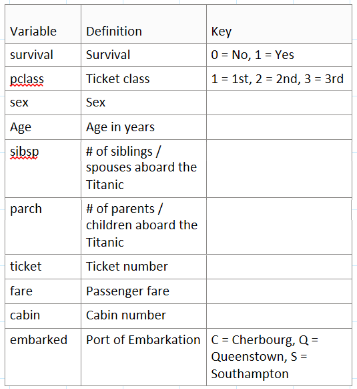

**Variable Notes**

* pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

* parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [ ]:
# Install Aequitas
!pip install aequitas

In [ ]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn import metrics as sklearn_metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
from aequitas.plotting import Plot
warnings.simplefilter('ignore')


In [ ]:
data_url = 'https://raw.githubusercontent.com/FauxGrit/Titanic-Fairness/main/train.csv'
df0 = pd.read_csv(data_url)
df0.head()

> Dataset Information:
> https://www.kaggle.com/code/alexisbcook/titanic-tutorial


In [ ]:
# Print shape of dataframe to determine number of rows and columns
print("Raw Titanic Data: \n\nNumber of Rows: ", df0.shape[0], "\nNumber of columns: ", df0.shape[1])

# Separate kids and adults
df0['Children'] = 0
df0.loc[df0['Age'] < 18, 'Children'] = 1

# Fill NaN values
df0['Age'] = df0['Age'].fillna(df0['Age'].mean())
df0['Fare'] = df0['Fare'].fillna(df0['Fare'].mean())
df0['Embarked'] = df0['Embarked'].fillna('Empty')
df0.head()
df1 = pd.get_dummies(data=df0, columns=['Sex','Embarked'])

# Drop collums to reduce redudancy
df1.drop(['Name','Ticket','Cabin', 'Sex_female'], axis=1, inplace=True)



### Let's explore

Basic **Statisics**

In [ ]:
df1.describe().T

### Let's build a model

In [ ]:
#Separate Inputs & Labels
X = df1.iloc[:,df1.columns != 'Survived'].values
y = df1.iloc[:, 1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
#Preserve passengerId to match predictions with orginal dataset
PassengerId_test = X_test[:,0]  # select 1st column

# Remove PassengerId from feature set prior to modeling
X_train = X_train[:,1:]         # retain all but 1st column
X_test = X_test[:,1:]

> When we talk about classification problem, we always mean that we’re trying to predict a categorical, usually binary, label, outcome or class Y
 from features X(which may or may not be categorical).

In [ ]:
# Scale and Normalize Data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# Initialize and fit model
rf = RandomForestClassifier(max_depth=3, random_state=0)
rf.fit(X_train, y_train)
sklearn_metrics.confusion_matrix(y_test, rf.predict(X_test))
cf_matrix = sklearn_metrics.confusion_matrix(y_test, rf.predict(X_test))

cfm_labels = ['True Negative','False Positive','False Negative','True Positive']

cfm_values = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

cfm_percent = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(cfm_labels,cfm_values,cfm_percent)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Random Forrest Classifier\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

print('Accuracy: ', '{percent:.2%}'.format(percent=rf.score(X_test, y_test)))

### Define Fairness Objectives

For our contrived example, we can use the fairness tree in the 1st link, to think through our survival classification models for children. We decide that False Postive Rate (fpr) is the fairness metric of interest.

We want to know if our model FALSELY predicts survival of children at a higher rate than the general population of passengers on the Titanic.

For more info: https://dssg.github.io/aequitas/input_data.html




[image](http://www.datasciencepublicpolicy.org/wp-content/uploads/2021/04/Fairness-Full-Tree.png)

### Aequitas Group Metrics
Below are descriptions of the absolute bias metrics calculated by Aequitas.

| Metric                        | Formula                                                                           | Description                                                                                                   |
|-------------------------------|-----------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------|
| **Predicted Positive**        | <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20PP_g">                                                                           | The number of entities within a group where the decision is positive, i.e.,  <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20%5Cwidehat%7BY%7D%3D1.">                |
| **Total Predictive Positive** | <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20K%20%3D%20%5Csum_%7BA%3Da_1%7D%5E%7BA%3Da_n%7D%20PP_%7Bg%28a_i%29%7D">                                      | The total number of entities predicted positive across groups defined by <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20A.">                               |
| **Predicted Negative**        | <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20PN_g">                                                                             | The number of entities within a group which decision is negative, i.e.,  <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20%5Clarge%20%5Cwidehat%7BY%7D%3D0.">                     |
| **Predicted Prevalence**      | <img src="http://latex.codecogs.com/gif.latex?PPrev_g%20%3D%20%5Cfrac%7BPP_g%7D%7B%7Cg%7C%7D%20%3D%20%5Ctext%7BPr%28%7D%5Cwidehat%7BY%7D%3D1%5C%3B%7C%5C%3BA%3Da_i%29">     | The fraction of entities within a group which were predicted as positive.                                     |
| **Predicted Positive Rate**   | <img src="http://latex.codecogs.com/gif.latex?PPR_g%20%3D%20%5Cfrac%7BPP_g%7D%7BK%7D%20%3D%20%5Ctext%7BPr%28%7DA%3Da_i%5C%3B%7C%5C%3B%5Cwidehat%7BY%7D%3D1%29">         | The fraction of the entities predicted as positive that belong to a certain group.                            |
| **False Positive**            | <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20FP_g">                                                                            | The number of entities of the group with <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20%5Clarge%20%5Cwidehat%7BY%7D%3D1"> and <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20%5Clarge%20Y%3D0.">                                           |
| **False Negative**            | <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20FN_g">                                                                            | The number of entities of the group with <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20%5Clarge%20%5Cwidehat%7BY%7D%3D0"> and <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20%5Clarge%20Y%3D1.">                                           |
| **True Positive**             | <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20TP_g">                                                                            | The number of entities of the group with <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20%5Clarge%20%5Cwidehat%7BY%7D%3D1"> and <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20%5Clarge%20Y%3D1.">                                          |
| **True Negative**             | <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20TN_g">                                                                            | The number of entities of the group with <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20%5Clarge%20%5Cwidehat%7BY%7D%3D0"> and <img src="http://latex.codecogs.com/gif.latex?%5Cinline%20%5Clarge%20Y%3D0.">                                          |
| **False Discovery Rate**      | <img src="http://latex.codecogs.com/gif.latex?FDR_g%20%3D%20%5Cfrac%7BFP_g%7D%7BPP_g%7D%20%3D%20%5Ctext%7BPr%28%7DY%3D0%5C%3B%7C%5C%3B%5Cwidehat%7BY%7D%3D1%2CA%3Da_i%29">  | The fraction of false positives of a group within the predicted positive of the group.                        |
| **False Omission Rate**       | <img src="http://latex.codecogs.com/gif.latex?FOR_g%20%3D%20%5Cfrac%7BFN_g%7D%7BPN_g%7D%20%3D%20%5Ctext%7BPr%28%7DY%3D1%5C%3B%7C%5C%3B%5Cwidehat%7BY%7D%3D0%2CA%3Da_i%29">  | The fraction of false negatives of a group within the predicted negative of the group.                        |
| **False Positive Rate**       | <img src="http://latex.codecogs.com/gif.latex?FPR_g%20%3D%20%5Cfrac%7BFP_g%7D%7BLN_g%7D%20%3D%20%5Ctext%7BPr%28%7D%5Cwidehat%7BY%7D%3D1%5C%3B%7C%5C%3BY%3D0%2CA%3Da_i%29"> | The fraction of false positives of a group within the labeled negative of the group.                          |
| **False Negative Rate**       | <img src="http://latex.codecogs.com/gif.latex?FNR_g%20%3D%20%5Cfrac%7BFN_g%7D%7BLP_g%7D%20%3D%20%5Ctext%7BPr%28%7D%5Cwidehat%7BY%7D%3D0%5C%3B%7C%5C%3BY%3D1%2C%20A%3Da_i%29">  | The fraction of false negatives of a group within the labeled positives of the group.

In [ ]:
# Set attributes to audit as "Age_Level" and the reference group to "Adult"
attributes_and_reference_groups={'Age_Level': 'Adult'}
attributes_to_audit = list(attributes_and_reference_groups.keys())

# False Positive Rate --> error rate when predicting survival
metrics = ['fpr']

# Used in visualization to define tolerance for disparity
disparity_tolerance = 1.2
# Convert arrays back into a dataframe for Aequtas consumption
dfAequitas = pd.DataFrame(X_test, columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Child',
       'Sex_male', 'Embarked_C', 'Embarked_Empty', 'Embarked_Q', 'Embarked_S'])

# Add the required column for 'label_value'
dfAequitas['label_value'] = y_test

# Convert Children binary data into Age_Level column with categical data for clarity in visualization
dfAequitas['Age_Level'] = 'Adult' # ‘Adult’ as the reference group
dfAequitas.loc[dfAequitas['Child'] > 0, 'Age_Level'] = 'Child'

# dfAequitas.tail(10)

# Initialize Aequitas classes
g = Group() # The Group( ) class is used to hold confusion matrix calculations and related metrics for each subgroup.
b = Bias() #  Bias( ) class is used to hold disparity calculations between groups.

### Run some analysis

In [ ]:
dfAequitas['score'] = rf.predict(X_test)

# get_crosstabs returns a df of the group counts and group value bias metrics
xtab, _ = g.get_crosstabs(dfAequitas, attr_cols=attributes_to_audit)
bdf = b.get_disparity_predefined_groups(xtab, original_df=dfAequitas,
                              ref_groups_dict=attributes_and_reference_groups)

# plot disparity
ap.disparity(bdf, metrics,'Age_Level',fairness_threshold = disparity_tolerance)

Immediately we see that the subgroup of children are in the red, outside of our **20%** tolerance for disparity

> The plot is interactive try clicking around!

In [ ]:
# bdf[['attribute_name', 'attribute_value'] + b.list_disparities(bdf)]

In [ ]:
absolute_metrics = g.list_absolute_metrics(xtab)
# xtab[['attribute_name', 'attribute_value'] + absolute_metrics]

#### View calculated counts across sample population groups

In [ ]:
# xtab[[col for col in xtab.columns if col not in absolute_metrics]]

#### View calculated absolute metrics for each sample population group

In [ ]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

##### How do I interpret biases in my model?
In the slice of the crosstab dataframe created by the `Group()` class **`get_crosstabs()`** method directly above, we see that Adults have a false positive rate (`fpr`) of 6%, while Children have a false positive rate of only .17%. This means that Adult people are far more likely to be falsely labeled as high-risk than children. On the other hand, false ommision rates (`for`) and false discovery rates (`fdr`) are much closer for those two groups.

In [ ]:
dfA = dfAequitas[['score','label_value','Age_Level']].copy()
dfA['PassengerId'] = PassengerId_test.astype(int)
df0 = df0[['PassengerId','Pclass','Sex']].copy()
dfA = dfA.merge(df0, on='PassengerId', how='left')
dfA['Pclass'].replace([1, 2, 3], ['Upper Class', 'Middle Class', 'Lower Class'], inplace=True)
dfA['Sex'].replace(['male', 'female'], ['Male', 'Female'], inplace=True)
dfA.rename(columns={'PassengerId': 'entity_id'}, inplace=True)
dfA = dfA[ ['entity_id'] + [ col for col in dfA.columns if col != 'entity_id' ] ]
# dfA.h÷ead()

## What levels of disparity exist between population groups?

### _Aequitas Bias() Class_
We use the Aequitas `Bias()` class to calculate disparities between groups based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method described above. Disparities are calculated as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for black defendants vis-a-vis whites is:
$$Disparity_{FNR} =  \frac{FNR_{child}}{FNR_{adult}}$$

Below, we use **`get_disparity_predefined_groups()`** which allows us to choose reference groups that clarify the output for the practitioner.

The Aequitas `Bias()` class includes two additional get disparity functions: **`get_disparity_major_group()`** and **`get_disparity_min_metric()`**, which automate base group selection based on sample majority (across each attribute) and minimum value for each calculated bias metric, respectively.

The **`get_disparity_predefined_groups()`** allows user to define a base group for each attribute, as illustrated below.

#### Disparities Calculated Calcuated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate Disparity | 'tpr_disprity' |
| True Negative Rate | 'tnr_disparity' |
| False Omission Rate | 'for_disparity' |
| False Discovery Rate | 'fdr_disparity' |
| False Positive Rate | 'fpr_disparity' |
| False NegativeRate | 'fnr_disparity' |
| Negative Predictive Value | 'npv_disparity' |
| Precision Disparity | 'precision_disparity' |
| Predicted Positive Ratio$_k$ Disparity | 'ppr_disparity' |
| Predicted Positive Ratio$_g$ Disparity | 'pprev_disparity' |


Columns for each disparity are appended to the crosstab dataframe, along with a column indicating the reference group for each calculated metric (denoted by `[METRIC NAME]_ref_group_value`). We see a slice of the dataframe with calculated metrics in the next section.

In [ ]:
g = Group()
b = Bias()
xtab, _ = g.get_crosstabs(dfA)
aqp = Plot()

In [ ]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=dfA,
                                        ref_groups_dict={'Age_Level':'Adult', 'Sex':'Male', 'Pclass':'Upper Class'},
                                        alpha=0.05, check_significance=True,
                                        mask_significance=True)
bdf.style

# # View disparity metrics added to dataframe
# bdf[['attribute_name', 'attribute_value'] +
#      b.list_disparities(bdf) + b.list_significance(bdf)].style

In [ ]:
metrics = ['fpr','fdr']
disparity_tolerance = 1.25
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

### How do I interpret calculated disparity ratios?
The calculated disparities from the dataframe returned by the `Bias()` class **`get_disparity_`** methods are in relation to a reference group, which will always have a disparity of 1.0.

The differences in False Positive Rates, noted in the discussion of the `Group()` class above, are clarified using the disparity ratio (`fpr_disparity`). Children people are identified as surviving 2.8 times the rate for adults.

As seen above, False Discovery Rates have much less disparity (`fdr_disparity`), or fraction of false postives over predicted positive in a group. As reference groups have disparity = 1 by design in Aequitas, the lower disparity is highlighted by the `fdr_disparity` value close to 1.0 (0.1.2) for the age attribute group 'children' when disparities are calculated using predefined base group 'adult'.

In [ ]:
p = aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fnr','fpr'], ncols=2)


In [ ]:
# a = aqp.plot_group_metric_all(xtab, ncols=2)

In [ ]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=dfA, ref_groups_dict={'Sex':'Male', 'Pclass':'Upper Class', 'Age_Level':'Adult'}, alpha=0.05, mask_significance=True)
# bdf.style

In [ ]:
# aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='Pclass', significance_alpha=0.05)

Treemap of disparity representation in false positive rates across all of the attributes.

In [ ]:
majority_bdf = b.get_disparity_major_group(xtab, original_df=dfA, mask_significance=True)
j = aqp.plot_disparity_all(majority_bdf, metrics=['fpr_disparity'], significance_alpha=0.05)

- The relative size of each group is provided by the area.
- The darker the color the larger the disparity.
  - Brown means a higher false positive rate than the reference and teal means lower. The reference group is automatically selected as the group with the largest population.


Interpreting the plots:
- Children have a much higher false positive rate than Adults,
- Upper Class Passengers have a much lower false positive rate than Lower Class, and
- Females have a much higher false positive rate than males.

# Fairness

In [ ]:
f = Fairness()
# The Fairness() class includes a method to quickly return a list of fairness determinations from the dataframe returned by the get_group_value_fairness() method.
fdf = f.get_group_value_fairness(bdf)
parity_detrminations = f.list_parities(fdf)
# fdf[['attribute_name', 'attribute_value'] + absolute_metrics + b.list_disparities(fdf) + parity_detrminations].style

### Interpreting parities
 Children are 3 time  as lakely to have false positives compared to adults!


 In real terms, 14.2 of Children who did not periced were classified as surviving, compared with 5.6% of adults.

In [ ]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

### Overall Fairness
The **`get_overall_fairness()`** function gives a quick boolean assessment of the output of **`get_group_value_fairness()`** or **`get_group_attribute_fairness()`**, returning a dictionary with a determination across all attributes for each of:
- Unsupervised Fairness
- Supervised Fairness
- Overall Fairness

In [ ]:
gof = f.get_overall_fairness(fdf)
gof

## Things to try

1. Try leveraging a diffrent classifier
- `xg = xgb.XGBClassifier(); xg.fit(X_train, y_train) `
-
2. Interpret the new predictions




## Mitigatate Model Bias



1. Improve the world!
2. Improve the input data
3. Fairness as a model selection method (Performance vs Fairness)
4. Adanced training texhniques
  - http://proceedings.mlr.press/v54/zafar17a/zafar17a.pdf
  - https://arxiv.org/pdf/1610.02413.pdf
  - https://arxiv.org/pdf/1808.00023.pdf

Check out:
1. https://fairlearn.org/
2. https://ai-fairness-360.org/